In [ ]:
!git clone https://github.com/Im-JihyunKim/2025_LGE_DNN.git # colab 사용 시

In [ ]:
# Local PC로 실습하는 경우 실행 x / 단 작업경로를 2024_LGE_CNN으로 맞춰주기
%cd /content/202d_LGE_DNN

In [1]:
# !pip install IPython
from IPython.display import Image

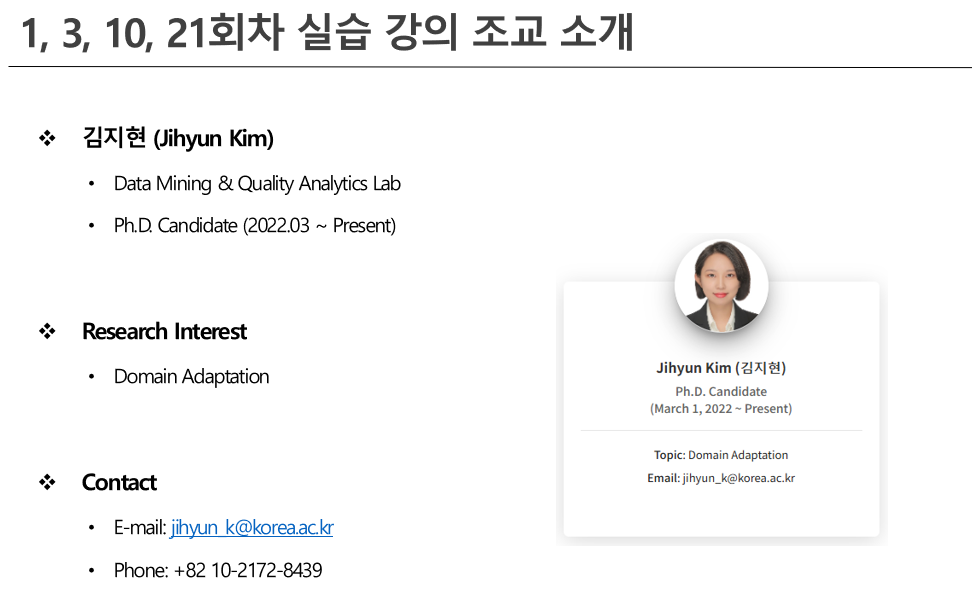

In [3]:
Image('images/img0.png')

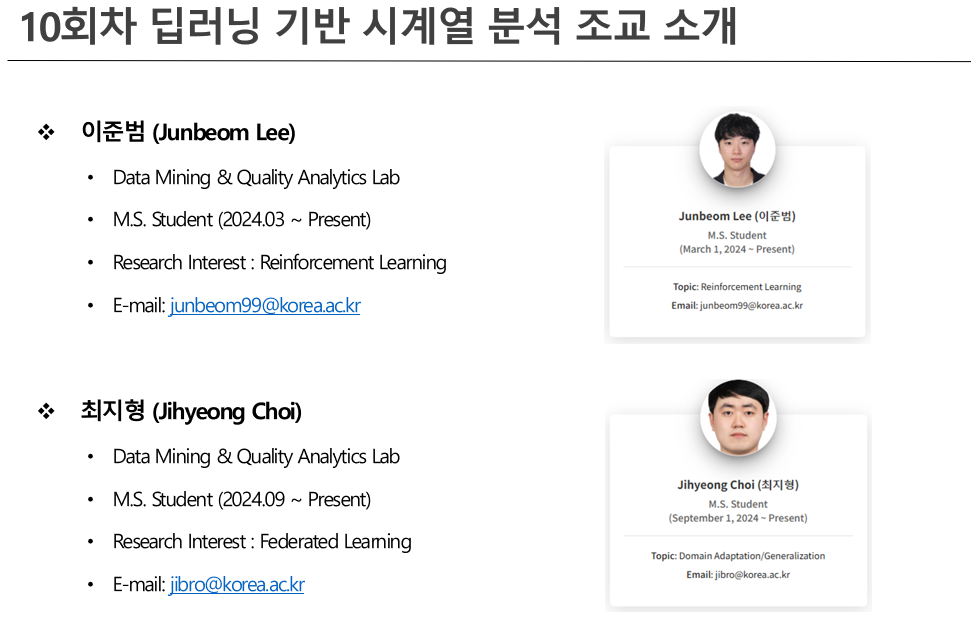

In [4]:
Image('images/img00.PNG')

# TO DO: PyTorch 역전파 알고리즘 함수화

모델 학습에 필요한 여러가지 모듈을 함수화 하여 편리하게 사용

In [5]:
''' 기본 모듈 및 시각화 모듈'''
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, time, random
from glob import glob

'''CNN을 위한 딥러닝 모듈'''
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim

''' 결과 평가용 모듈 '''
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings(action='ignore')

## 0. 학습 전 준비

### GPU 확인 및 사용할 device 설정

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Seedn/Random state 고정
- 실험 결과 재현성을 위함

In [7]:
# 똑같은 결과를 얻기 위한 시드 고정
seed = 0
torch.manual_seed(seed) # torch cpu seed 고정
torch.cuda.manual_seed(seed) # torch gpu seed 고정
torch.cuda.manual_seed_all(seed) # torch multi-gpu seed 고정
np.random.seed(seed) # numpy seed 고정
random.seed(seed) # python seed 고정

## 1. Dataset 및 DataLoader 정의

### 센서 데이터셋을 기반으로 사람의 행동을 분류
#### Human Activity Recognition: 30명의 실험자들에 대해서 각자 스마트폰을 허리에 착용하고 6가지 활동 (Walking, Walking Upstairs, Walking Downstairs, Sitting, Standing, Laying)을 수행할 때 측정된 센서 데이터로 구성된 데이터셋
- 총 9종류의 센서로 이루어진 데이터이며, 각 센서는 50Hz 단위로 측정이 이루어짐.
- 2.56초에 해당하는 window_size를 적용하여 다변량 센서 데이터를 입력 변수(X)로, 활동을 출력 변수(Y)로 분류하는 것이 목표
- cf. [Tensorflow로 짜인 코드로 비교](https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/)

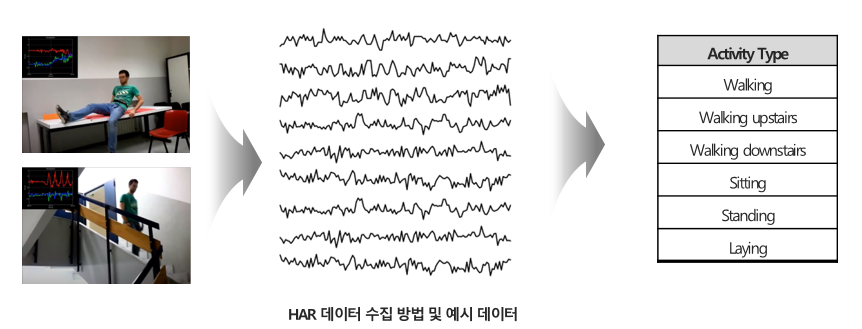

In [8]:
Image('./images/HAR-1.PNG')

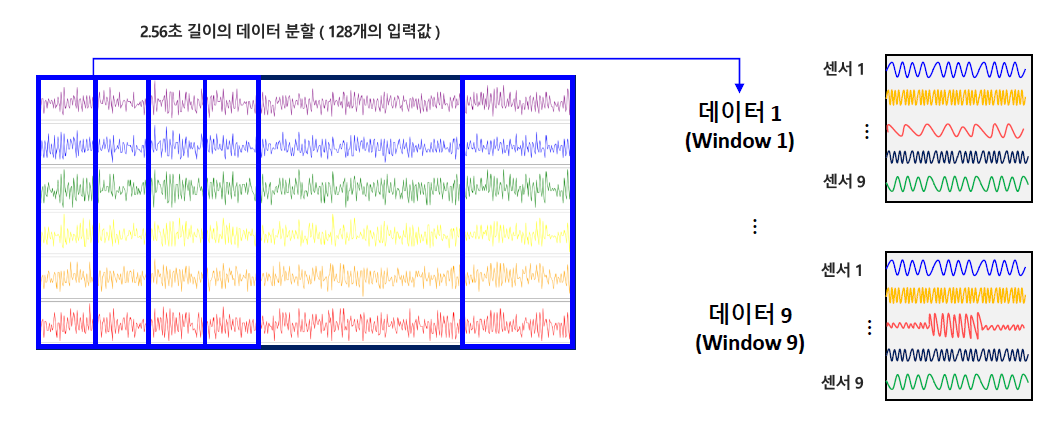

In [9]:
Image('./images/HAR.PNG')

### 1-1. 전처리 수행

In [10]:
## 데이터 로드하기 ##
data_dir = './data/UCI HAR Dataset/'

"""x 데이터 불러온 후 전처리"""
train_path = glob(os.path.join(data_dir, 'train/Inertial Signals/*'))
test_path = glob(os.path.join(data_dir, 'test/Inertial Signals/*'))
print(train_path)

['./data/UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt', './data/UCI HAR Dataset/train/Inertial Signals/body_acc_y_train.txt', './data/UCI HAR Dataset/train/Inertial Signals/body_acc_z_train.txt', './data/UCI HAR Dataset/train/Inertial Signals/body_gyro_x_train.txt', './data/UCI HAR Dataset/train/Inertial Signals/body_gyro_y_train.txt', './data/UCI HAR Dataset/train/Inertial Signals/body_gyro_z_train.txt', './data/UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt', './data/UCI HAR Dataset/train/Inertial Signals/total_acc_y_train.txt', './data/UCI HAR Dataset/train/Inertial Signals/total_acc_z_train.txt']


- 데이터 확장자가 .txt인 것을 알 수 있음

In [11]:
# txt 파일로 존재하는 데이터 line 별로 읽어오기
# (num_data, sequence_length)의 data 생성

def create_data(path_name):
    with open(path_name) as f:  # os.path.join(path, filename) 경로의 file을 f 라는 이름으로 open
        data = []
        for line in f:  # f 라는 이름의 txt 데이터를 line 별로 for문을 돌면서 읽기
            num = [float(l) for l in line.split()]  # f라는 이름의 file 내의 line을 for문을 돌며 float 형태로 변환
            data.append(num)  # 각 값을 data로 만들기 위해 list 안에 담기
    data = np.array(data).reshape(-1,128)  # list 형태의 데이터를 np.array 형태로 바꾸어주기

    return data

In [12]:
# Conv1d 의 input 형태 : (batch_size,num_channels,sequence_length)
# 각 센서별로 나오는 데이터를 (num_data,num_channels,sequence_length)형태로 변경
train_data = []
for i in range(len(train_path)):
    data = create_data(train_path[i])
    train_data.append(data)
train_data = np.transpose(np.array(train_data), (1,0,2))  # np.array(train_data)의 형태는 (9, 7532, 128) -> transpose를 통해 (7352, 9, 128)로 변환

test_data = []
for i in range(len(test_path)):
    data = create_data(test_path[i])
    test_data.append(data)
test_data = np.transpose(np.array(test_data), (1,0,2))

print(train_data.shape, '\n', test_data.shape)

(7352, 9, 128) 
 (2947, 9, 128)


- .txt 파일의 데이터를 읽고 np.array 형태의 데이터셋으로 구축
- x data shape = (N, C, T)
    - N: 관측치/샘플 개수
    - C: 채널 개수 (센서 개수)
    - T: 관측치 별 time step (한 관측치의 dimension 크기)

In [13]:
# 1~6 으로 class label이 형성되어 있으므로 0~5까지 맞춰주기 위해서 -1 
# 0(Walking) / 1(Walking Upstairs) / 2(Walking Downstairs) / 3(Sitting) / 4(Standing) / 5(Laying)

"""y 데이터 불러온 후 전처리"""
train_label = pd.read_csv(os.path.join(data_dir, 'train/y_train.txt'), header=None, sep=' ')
train_label = np.array(train_label[0])-1  # 1,2,3,4,5 -> 0,1,2,3,4

test_label = pd.read_csv(os.path.join(data_dir, 'test/y_test.txt'), header=None, sep=' ')
test_label = np.array(test_label[0])-1

5    1407
4    1374
3    1286
0    1226
1    1073
2     986
dtype: int64

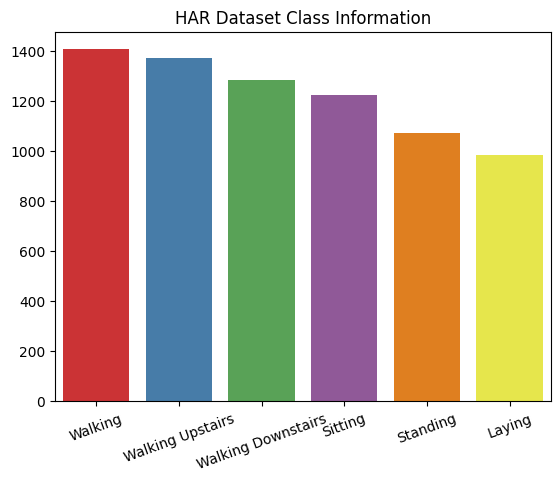

In [14]:
"""y 데이터 EDA"""
sns.barplot(x=['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying'], 
            y=pd.Series(train_label).value_counts().values, palette='Set1');
plt.xticks(rotation=20)
plt.title("HAR Dataset Class Information");

pd.DataFrame(train_label).value_counts()

- Class 별 불균형이 심하지 않음

In [15]:
"""train/valid/test 분할"""
len_train = int(len(train_data) * 0.8)  # 기존 학습 데이터 중 80%는 학습용, 그 외는 검증용으로 활용

"""Note: 시계열 데이터는 random split을 하지 않음! 순차적으로 train/valid/test를 나누어주는 것이 일반적."""
new_train_data = train_data[:len_train,:,:]
new_train_label = train_label[:len_train]

val_data = train_data[len_train:,:,:]
val_label = train_label[len_train:]

#### 참고. Time Series Augmentation for Deep Learning
- Jittering: 시계열 데이터에 작은 noise를 추가하여 데이터 각 포인트에 임의의 변동(jitter)을 추가
    - noise 크기는 데이터의 scale과 분산을 고려하여 신중히 선택 필요
- Scaling: 시계열 데이터의 스케일을 변경(절대적인 값의 범위를 조금 변경)하는 기법으로, 값의 절대적 크기보다는 데이터의 패턴이나 추세를 학습하는 데 더 집중 가능
- 추가적인 기법은 [논문](https://arxiv.org/pdf/2002.12478.pdf) 참고

In [16]:
"""Augmentation"""
# timeseries augmentation은 한정적!

def TS_Jitter(X, sigma=0.001):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise

def TS_Scaling(X, sigma=0.2):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

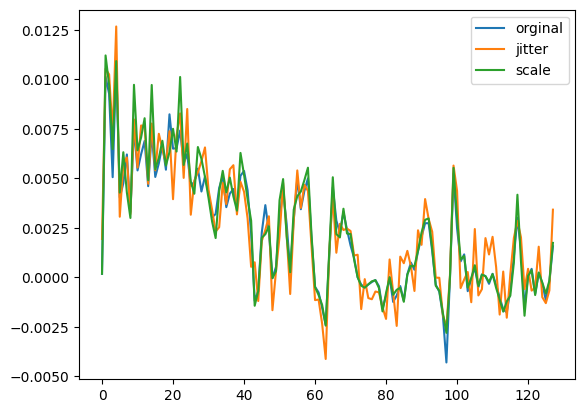

In [17]:
ts = new_train_data[0]
ts_jitter = TS_Jitter(ts)
ts_scale = TS_Scaling(ts)

plt.plot(ts[0], label='orginal')
plt.plot(ts_jitter[0], label='jitter')
plt.plot(ts_scale[0], label='scale')
plt.legend()
plt.show();

#### 전처리 과정을 함수화 해보자!

In [18]:
# 데이터 전처리 및 로드에 필요한 하이퍼파라미터 정의
configs = {
    'data_dir':"./data/UCI HAR Dataset/",
    'jitter':False,
    'scale':False,
    'aug_prob':.5,

    'batch_size':64,
}

In [18]:
class HAR_preprocess():
    def __init__(self, configs):
        self.configs = configs

        # load x data
        train_data = self.make_data(glob(os.path.join(self.configs['data_dir'], 'train/Inertial Signals/*')))
        test_data = self.make_data(glob(os.path.join(self.configs['data_dir'], 'test/Inertial Signals/*')))

        # load y data
        train_label = (pd.read_csv(os.path.join(self.configs['data_dir'], 'train/y_train.txt'), 
                                    header=None, sep=' ').values-1).squeeze()
        test_label = (pd.read_csv(os.path.join(self.configs['data_dir'], 'test/y_test.txt'), 
                                    header=None, sep=' ').values-1).squeeze()

        # split train/valid/test
        train_data, train_label, valid_data, valid_label = self.split_train_valid(train_data, train_label, train_ratio=0.8)

        self.trainset = {'X': train_data, 'y': train_label}
        self.validset = {'X': valid_data, 'y': valid_label}
        self.testset = {'X': test_data, 'y': test_label}

    @staticmethod
    def split_train_valid(x, y, train_ratio:float=0.8):
        len_train = int(len(x)*train_ratio)

        train_data, train_label = x[:len_train,:,:], y[:len_train]
        valid_data, valid_label = x[len_train:,:,:], y[len_train:]

        return train_data, train_label, valid_data, valid_label

    def make_data(self, data_path):
        data = []
        for i in range(len(data_path)):
            data.append(self.create_data(data_path[i]))
        data = np.transpose(np.array(data), (1,0,2))
        return data
    
    @staticmethod
    def create_data(path_name):
        with open(path_name) as f:  # os.path.join(path, filename) 경로의 file을 f 라는 이름으로 open
            data = []
            for line in f:  # f 라는 이름의 txt 데이터를 line 별로 for문을 돌면서 읽기
                num = [float(l) for l in line.split()]  # f라는 이름의 file 내의 line을 for문을 돌며 float 형태로 변환
                data.append(num)  # 각 값을 data로 만들기 위해 list 안에 담기
        data = np.array(data).reshape(-1,128)  # list 형태의 데이터를 np.array 형태로 바꾸어주기
        return data
    
    def jitter(self, x, sigma=0.001):
        noise = np.random.normal(loc=0, scale=sigma, size=x.shape)
        return x + noise

    def scaling(self, x, sigma=0.2):
        scaling_factor = np.random.normal(loc=1.0, scale=sigma, size=(1, x.shape[1])) # shape=(1,3)
        noise = np.matmul(np.ones((x.shape[0],1)), scaling_factor)
        return x*noise

In [19]:
get_data = HAR_preprocess(configs)
get_data.trainset['X'].shape, get_data.trainset['y'].shape

((5881, 9, 128), (5881,))

### 1-2. Custom Dataset 만들기

In [20]:
# HARDataset
class HARDataset(Dataset):
    def __init__(self, configs, mode:str):
        self.configs = configs
        self.get_data = HAR_preprocess(self.configs)

        if mode == "train":
            self.X, self.y = torch.Tensor(self.get_data.trainset['X']), torch.Tensor(self.get_data.trainset['y'])
        elif mode == "valid":
            self.X, self.y = torch.Tensor(self.get_data.validset['X']), torch.Tensor(self.get_data.validset['y'])
        elif mode == "test":
            self.X, self.y = torch.Tensor(self.get_data.testset['X']), torch.Tensor(self.get_data.testset['y'])
        else:
            raise ValueError

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        # Transformation
        rand_prob = np.random.uniform()
        if self.configs['jitter'] and rand_prob > self.configs['aug_prob']:
            X = self.get_data.jitter(X)
        if self.configs['scale'] and rand_prob > self.configs['aug_prob']:
            X = self.get_data.scaling(X)

        return {'X':X.float(), 'y':y}

In [21]:
print('Train 데이터 수', HARDataset(configs, mode="train").X.size(0))
print('Valid 데이터 수', HARDataset(configs, mode="valid").X.size(0))
print('Test 데이터 수', HARDataset(configs, mode="test").X.size(0))

Train 데이터 수 5881
Valid 데이터 수 1471
Test 데이터 수 2947


#### DataLoader 호출 함수화

In [22]:
def get_dataloader(configs):
    trainset = HARDataset(configs, mode="train")
    validset = HARDataset(configs, mode="valid")
    testset = HARDataset(configs, mode="test")

    trainloader = DataLoader(trainset, batch_size=configs['batch_size'], shuffle=True, drop_last=False)
    validloader = DataLoader(validset, batch_size=configs['batch_size'], shuffle=False, drop_last=False)
    testloader = DataLoader(testset, batch_size=configs['batch_size'], shuffle=False, drop_last=False)

    return trainloader, validloader, testloader

## 2. Deep Neural Network Model 정의

### __Conv1d__ : (in_channels,out_channels,kernel_size)
- in_channels : input으로 들어오는 데이터의 채널 개수(다변량 시계열 데이터에서는 센서의 개수)
- out_channels : Convolution 연산 이후 만들어지는 채널의 개수
- kernel_size : Filter의 크기를 의미하며 하나의 Filter에서 고려할 시점의 개수

### Model
- torch.nn.Module 상속받기
- \_\_init\_\_: 모델에서 사용할 layer 정의
- forward: 데이터를 입력받아 모델 진행 순서 결정

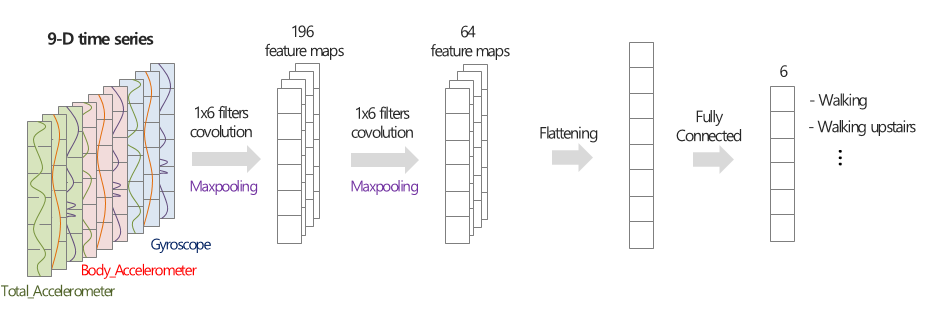

In [19]:
Image('./images/CNN1D.PNG')

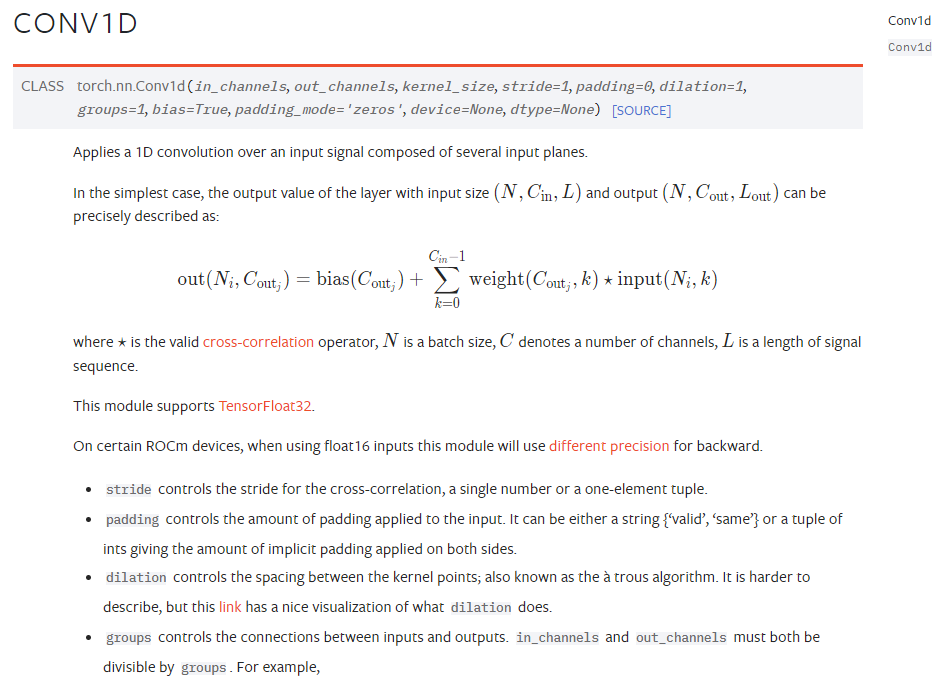

In [21]:
Image('./images/conv1d-torch.png')

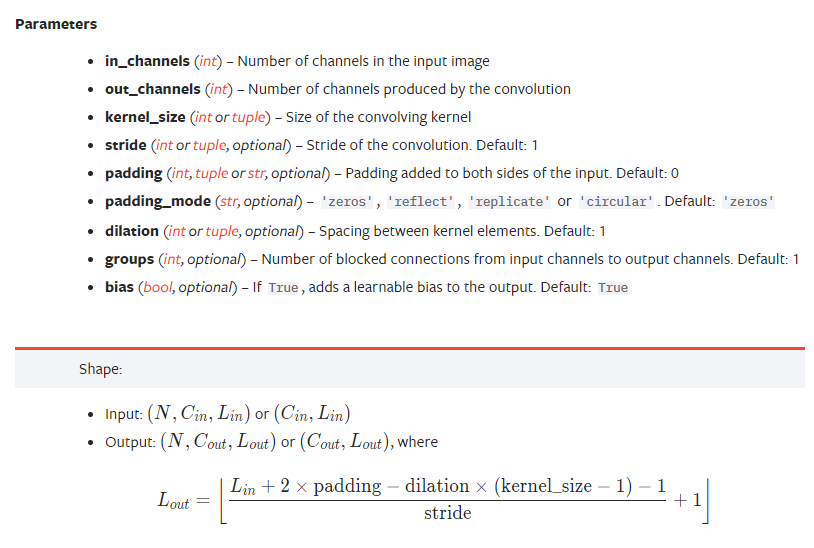

In [24]:
Image('./images/conv1d-torch2.png')

In [25]:
model_configs = {
    'in_channels':9,     # 채널 개수가 9
    'seq_len':128,       # 샘플 당 timestep(sequence length) 128
    'num_classes':6,     # class 개수
    'mid_channels':196,  # Conv1D 첫번째 conv에서 우리가 사용할 필터 개수
    'out_channels':64,   # Conv1D 마지막 conv에서 우리가 사용할 필터 개수 
    'kernel_size':6,     # kernel height
    'stride':1,          # kernel 이동 간격
    'dropout_rate':.1,   # dropout rate
}

configs.update(model_configs)  # model 관한 configs 내용도 포함시켜서 업데이트
configs

{'data_dir': './data/UCI HAR Dataset/',
 'jitter': False,
 'scale': False,
 'aug_prob': 0.5,
 'batch_size': 64,
 'in_channels': 9,
 'seq_len': 128,
 'num_classes': 6,
 'mid_channels': 196,
 'out_channels': 64,
 'kernel_size': 6,
 'stride': 1,
 'dropout_rate': 0.1}

In [26]:
class CNN1d(nn.Module):
    def __init__(self, configs):
        super().__init__()
        
        self.seq_len = configs['seq_len']
        self.num_classes = configs['num_classes']
        self.in_channels = configs['in_channels']
        self.mid_channels = configs['mid_channels']
        self.out_channels = configs['out_channels']
        self.kernel_size = configs['kernel_size']
        self.stride = configs['stride']
        self.p = configs['dropout_rate']

        '''모델에 필요한 layer 정의'''
        self.conv1 = nn.Sequential(
            nn.Conv1d(self.in_channels, self.mid_channels,
                        self.kernel_size, self.stride),
            nn.BatchNorm1d(self.mid_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(self.p),
        )
        # calculate sequence length (L_out)
        L_out = self.calculate_output_length(self.seq_len, self.kernel_size, self.stride)//2
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(self.mid_channels, self.out_channels,
                        self.kernel_size, self.stride),
            nn.BatchNorm1d(self.out_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(self.p),
        )
        # calculate sequence length (L_out)
        L_out = self.calculate_output_length(L_out, self.kernel_size, self.stride)//2

        self.classifier = nn.Linear(self.out_channels*L_out, self.num_classes)
    
    @staticmethod
    def calculate_output_length(input_seq, kernel_size, stride, padding=0, dilation=1):
        return (input_seq + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1

    def forward(self,x):
        
        ''' x를 입력받아 진행할 순서 설정 '''
        out = self.conv1(x) 
        out = self.conv2(out)   # (B, out_channels, L_out)
        out = out.view(out.size(0), -1)  # flatten: (B, out_channels, L_out) -> (B, out_channels * L_out)
        out = self.classifier(out)  # (B, num_classes)
        
        return out

In [27]:
model = CNN1d(configs)
summary(model, input_size=(configs['in_channels'], configs['seq_len']), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 196, 123]          10,780
       BatchNorm1d-2             [-1, 196, 123]             392
              ReLU-3             [-1, 196, 123]               0
         MaxPool1d-4              [-1, 196, 61]               0
           Dropout-5              [-1, 196, 61]               0
            Conv1d-6               [-1, 64, 56]          75,328
       BatchNorm1d-7               [-1, 64, 56]             128
              ReLU-8               [-1, 64, 56]               0
         MaxPool1d-9               [-1, 64, 28]               0
          Dropout-10               [-1, 64, 28]               0
           Linear-11                    [-1, 6]          10,758
Total params: 97,386
Trainable params: 97,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

## 3. Loss Function & Optimizer 정의

### 3-1. Loss Function 정의
- Cross Entropy Loss!

In [28]:
criterion = nn.CrossEntropyLoss()

### 3-2. Optimizer 정의

In [29]:
opt_configs = {
    'optimizer':'adam',
    'lr':1e-4,
    'momentum':0.9,
    'weight_decay':0}
    
configs.update(opt_configs)
configs

{'data_dir': './data/UCI HAR Dataset/',
 'jitter': False,
 'scale': False,
 'aug_prob': 0.5,
 'batch_size': 64,
 'in_channels': 9,
 'seq_len': 128,
 'num_classes': 6,
 'mid_channels': 196,
 'out_channels': 64,
 'kernel_size': 6,
 'stride': 1,
 'dropout_rate': 0.1,
 'optimizer': 'adam',
 'lr': 0.0001,
 'momentum': 0.9,
 'weight_decay': 0}

In [30]:
def get_optimizer(configs, model):
    if configs['optimizer'] == "sgd":
        optimizer = optim.SGD(params=model.parameters(), lr=configs['lr'],
                              momentum=configs['momentum'], weight_decay=configs['weight_decay'])

    elif configs['optimizer'] == "adam":
        optimizer = optim.Adam(params=model.parameters(), lr=configs['lr'], 
                                    betas=(configs['momentum'], 0.999), # (momentum, adaptive lr momentum)
                                    weight_decay=configs['weight_decay'])
    else:
        print("Invalid optimizer name, it should be one of ['sgd', 'adam']. Exiting...")
        exit()

    return optimizer

## 4. Forward & Backward

### 4-1. 학습에 필요한 하이퍼파라미터 정의
- 모델을 학습시키는 데 사용자가 직접 정의 해주어야 하는 모든 값들을 사전에 지정

In [31]:
train_configs = {'seed':0,
                'num_epochs':15,
                'save_dir': './results/',
                'visualize': True}

configs.update(train_configs)
configs

{'data_dir': './data/UCI HAR Dataset/',
 'jitter': False,
 'scale': False,
 'aug_prob': 0.5,
 'batch_size': 64,
 'in_channels': 9,
 'seq_len': 128,
 'num_classes': 6,
 'mid_channels': 196,
 'out_channels': 64,
 'kernel_size': 6,
 'stride': 1,
 'dropout_rate': 0.1,
 'optimizer': 'adam',
 'lr': 0.0001,
 'momentum': 0.9,
 'weight_decay': 0,
 'seed': 0,
 'num_epochs': 15,
 'save_dir': './results/',
 'visualize': True}

### 4-2. Train 과정 함수화

In [32]:
def train(device, model, trainloader, criterion, optimizer):
    num_iterations = len(trainloader)
    train_history = {'loss': torch.zeros(num_iterations),      # 모델의 손실을 기록하기 위한 변수
                    'accuracy': torch.zeros(num_iterations)}  # 모델의 성능(accuracy)을 기록하기 위한 변수
    
    for i, batch in enumerate(trainloader):
        # X, y 데이터 명시, 두 텐서를 모델, 목적함수와 같은 device로
        X, y = batch['X'].to(device), batch['y'].to(device).long()

        # forward
        logits = model(X)  # model에 input_imgs를 입력으로 넣으면 자동으로 forward 함수가 호출되어 prediction을 output으로 도출

        # Loss 계산!
        loss = criterion(logits, y)

        """계산된 loss에서 gradient를 계산하는 역전파 함수: .backward()"""
        loss.backward()  # PyTorch 자동 미분

        """optimizer를 이용한 파라미터 업데이트"""
        optimizer.step()
        
        """Optimizer Gradient 초기화"""
        optimizer.zero_grad()

        # 모델 성능 계산!
        max_pred = torch.max(logits.detach(), dim=-1)[1] # 샘플 별 logit의 max 값들을 뽑기 -> [1]로 max 값들의 idx를 반환
                                                         # logit의 max 값은 모델이 해당 class로 예측했다는 의미
        accuracy = torch.eq(max_pred, y).sum().cpu().item() / len(y)  # 예측한 class와 정답이 얼마나 맞는지(eq) 비교하고, 맞은 개수를 합한 후 (sum) 평균 내기

        train_history['loss'][i] = loss.item()   # 'item()'은 tensor의 item 값 (상수 값)만 반환. tensor를 직접적으로 리스트에 append하면 불필요하게 메모리가 쌓이는 것 주의.
        train_history['accuracy'][i] = accuracy

    train_result = {k: v.mean().item() for k, v in train_history.items()}  # train의 loss, acc를 평균내어 결과 보기 

    return train_result

### 4-4. Valid (Evaluate) 과정 함수화

In [33]:
def evaluate(device, model, validloader, criterion):
    model.eval() # batchnorm, dropout 등 train할 때와 test할 때 연산이 다른 경우가 존재

    num_iterations = len(validloader)
    valid_history = {'loss': torch.zeros(num_iterations),      # 모델의 손실(loss)을 기록하기 위함
                    'accuracy': torch.zeros(num_iterations)}   # 모델의 성능(accuracy)을 기록하기 위함

    with torch.no_grad():  # 자동미분 연산 중지
        for i, batch in enumerate(validloader):
            X, y = batch['X'].to(device), batch['y'].to(device).long()
            logits = model(X)

            loss = criterion(logits, y)

            """loss를 backward 하지 않는 것에 주의"""

            # 모델 손실 및 성능 기록
            max_pred = torch.max(logits.detach(), dim=-1)[1]
            accuracy = torch.eq(max_pred, y).sum().cpu().item() / len(y)  # 예측한 class와 정답이 얼마나 맞는지(eq) 비교하고, 맞은 개수를 합한 후 (sum) 평균 내기

            valid_history['loss'][i] = loss.item()   # 모델 손실 저장
            valid_history['accuracy'][i] = accuracy  # 모델 성능 저장

    valid_result = {k: v.mean().item() for k, v in valid_history.items()}

    return valid_result

### 4-5. 모델 학습 추세 시각화 함수화

In [34]:
def visualize_model_training(configs, epoch_history):
    # Loss 추세 시각화
    sns.lineplot(x=range(1, configs['num_epochs']+1), y=epoch_history['train_loss'], label="Train Loss")
    sns.lineplot(x=range(1, configs['num_epochs']+1), y=epoch_history['valid_loss'], label="Valid Loss")
    plt.title("Train vs Valid Loss Graph")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc="best")
    plt.show()

    # 성능(Accuracy) 추세 시각화
    sns.lineplot(x=range(1, configs['num_epochs']+1), y=epoch_history['train_acc'], label="Train Accuracy")
    sns.lineplot(x=range(1, configs['num_epochs']+1), y=epoch_history['valid_acc'], label="Valid Accuracy")
    plt.title("Train vs Valid Accuracy Graph")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc="best")
    plt.show();

### 4-6. 모델 파라미터 저장 함수화
- Save parameters of the trained model

In [35]:
def save_checkpoint(save_dir, model):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
    
    save_model_dir = os.path.join(save_dir, 'HAR_model_checkpoint.pt')

    save_dict = {'model': model.state_dict()}
    torch.save(save_dict, save_model_dir)

### 4-7. Test 과정 함수화

In [36]:
def test(device, configs, model, testloader):
    """test model 정의"""
    saved_model = torch.load(os.path.join(configs['save_dir'], 'HAR_model_checkpoint.pt')) # 모델 불러오기
    parameters = saved_model['model']  # 'model'의 파라미터 불러오기
    model.load_state_dict(parameters)

    """test 과정에서 pred, true를 모두 반환"""
    test_result = {'pred': [], 'true': []}

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(testloader):
            X, y = batch['X'].to(device), batch['y'].to(device).long()
            
            logits = model(X) # B,2
            # 출력 값을 최대로 하는 인덱스(class 저장)
            pred = torch.argmax(logits, dim=1)

            test_result['pred'].extend(pred.squeeze().cpu().numpy())
            test_result['true'].extend(y.squeeze().cpu().numpy())

    return test_result

### 4-8. 모든 학습 프레임워크 함수화

In [37]:
def main(configs):
    """Step 1: 학습 전 세팅: device, seed, configs 확인, data 정의, model 정의, loss function 및 optimizer 정의"""
    # Device 정의
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # seed 정의
    torch.manual_seed(configs['seed']) # torch cpu seed 고정
    torch.cuda.manual_seed(configs['seed']) # torch gpu seed 고정
    torch.cuda.manual_seed_all(configs['seed']) # torch multi-gpu seed 고정
    np.random.seed(configs['seed']) # numpy seed 고정
    random.seed(configs['seed']) # python seed 고정

    # 우리가 설정한 하이퍼파라미터가 무엇인지 프린트하여 확인
    print(f"Configurations: \n {configs}")

    # 데이터 불러오기
    trainloader, validloader, testloader = get_dataloader(configs)
    
    # 모델 정의하기
    model = CNN1d(configs)
    # GPU로 모델 및 loss function 전송 (CPU에서 계산하는 경우 연산량에 따라 시간이 오래 걸림)
    model, criterion = model.to(device), nn.CrossEntropyLoss().to(device)

    # optimizer 정의
    optimizer = get_optimizer(configs, model)  # 앞서 정의해두었던 함수 호출

    # training
    best_acc = 0.0              # 최종적으로 저장할 모델을 판단할 기준 설정 (초기화)
    best_epoch = 0.0            # 최종 모델이 몇 번째 epoch에서 도출되는지 저장 위함 (초기화)
    epoch_history = {'train_loss': [], 'train_acc': [],
                     'valid_loss': [], 'valid_acc': []}

    start = time.time()

    """Step 2: 학습 시작"""
    for epoch in range(1, configs['num_epochs']+1):  

        print('-'*15, f'Epoch: {epoch}', '-'*15)

        train_result = train(device, model, trainloader, criterion, optimizer)     # 앞서 정의해두었던 함수 호출
        valid_result = evaluate(device, model, validloader, criterion)  # 앞서 정의해두었던 함수 호출

        print(f"Train Loss: {train_result['loss']:.2f} | Train Accuracy: {train_result['accuracy']:.2f}")
        print(f"Valid Loss: {valid_result['loss']:.2f} | Valid Accuracy: {valid_result['accuracy']:.2f}")

        """Step 3: 학습 중 도출된 loss 및 acc 값들 저장"""
        epoch_history['train_loss'].append(train_result['loss'])
        epoch_history['train_acc'].append(train_result['accuracy'])
        epoch_history['valid_loss'].append(valid_result['loss'])
        epoch_history['valid_acc'].append(valid_result['accuracy'])

        """Step 4: 모델을 평가 (valid/eval) 하였을 때 성능 측면에서 가장 우수했던 모델을 저장"""
        if valid_result['accuracy'] > best_acc:
            best_acc = valid_result['accuracy']  # best acc 값 업데이트
            best_epoch = epoch                   # best epoch 값 업데이트
            save_checkpoint(configs['save_dir'], model)  # 앞서 정의해두었던 함수 호출

    # 최종적으로 선택된 모델에 대한 값 확인
    print(f"Best Valid Accuracy:{best_acc:.2f} | Best Epoch:{best_epoch}")

    # 학습 추세 시각화
    if configs['visualize']:
        visualize_model_training(configs, epoch_history)

    """Step 5: 모델 최종 성능 평가"""
    test_result = test(device, configs, model, testloader)
    # print(f"Test Accuracy  : {test_result['accuracy']:.2f} \n")

    # 학습/테스트에 소요된 시간 계산 후 출력
    end_sec = time.time() - start
    end_min = end_sec / 60
    print(f"Total Training Time: {end_min:.2f} minutes")

    return test_result

Configurations: 
 {'data_dir': './data/UCI HAR Dataset/', 'jitter': False, 'scale': False, 'aug_prob': 0.5, 'batch_size': 64, 'in_channels': 9, 'seq_len': 128, 'num_classes': 6, 'mid_channels': 196, 'out_channels': 64, 'kernel_size': 6, 'stride': 1, 'optimizer': 'adam', 'lr': 0.0001, 'momentum': 0.9, 'weight_decay': 0, 'seed': 0, 'num_epochs': 15, 'save_dir': './results/', 'dropout_rate': 0.1, 'visualize': True}
--------------- Epoch: 1 ---------------
Train Loss: 0.77 | Train Accuracy: 0.72
Valid Loss: 0.53 | Valid Accuracy: 0.85
--------------- Epoch: 2 ---------------
Train Loss: 0.31 | Train Accuracy: 0.91
Valid Loss: 0.36 | Valid Accuracy: 0.90
--------------- Epoch: 3 ---------------
Train Loss: 0.18 | Train Accuracy: 0.94
Valid Loss: 0.30 | Valid Accuracy: 0.91
--------------- Epoch: 4 ---------------
Train Loss: 0.13 | Train Accuracy: 0.96
Valid Loss: 0.29 | Valid Accuracy: 0.91
--------------- Epoch: 5 ---------------
Train Loss: 0.11 | Train Accuracy: 0.96
Valid Loss: 0.27 | 

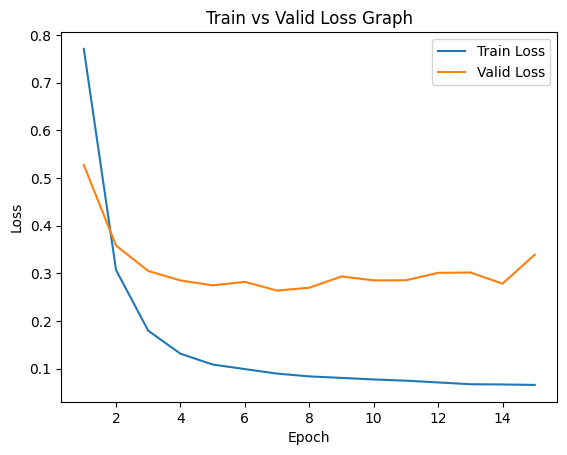

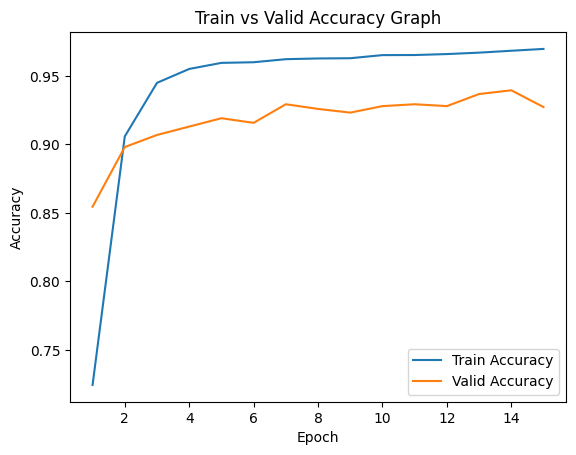

Total Training Time: 0.13 minutes


In [95]:
# 최종 main 함수 실행!!
test_result = main(configs)

### Test 결과 확인

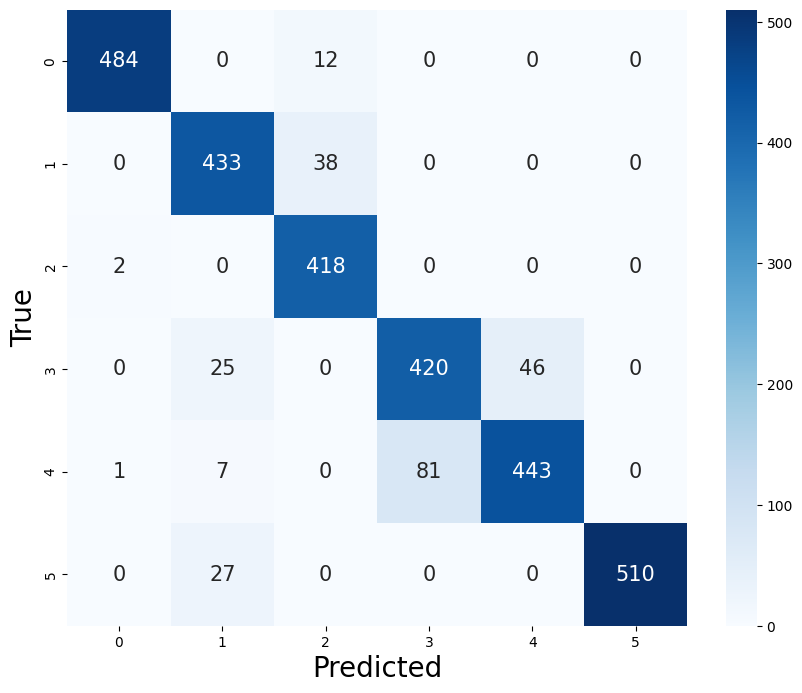

Test Accuracy   : 0.919
Test Sensitivity: 0.921
Test Precision  : 0.919
Test F1 Score   : 0.919


In [101]:
true, pred = test_result['true'], test_result['pred']

conf_mat = confusion_matrix(test_result['true'], test_result['pred'])

# confusion matrix 시각화
plt.figure(figsize=(10,8))
sns.heatmap(data=conf_mat, annot=True, fmt='d', annot_kws={'size':15}, cmap="Blues")
plt.xlabel('Predicted', size=20)
plt.ylabel('True', size=20)
plt.show()

# 평가지표 계산
test_acc = accuracy_score(true, pred)
test_rec = recall_score(true, pred, average='macro')
test_prec = precision_score(true, pred, average='macro')
test_f1 = f1_score(true, pred, average='macro')

print('Test Accuracy   : {:.3f}'.format(test_acc))
print('Test Sensitivity: {:.3f}'.format(test_rec))
print('Test Precision  : {:.3f}'.format(test_prec))
print('Test F1 Score   : {:.3f}'.format(test_f1))